In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train"
val_dir = "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/validation"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_files = os.listdir(train_dir)
validation_files = os.listdir(val_dir)
print("Files in dataset directory:", train_files)
print("Files in dataset directory:", validation_files)

Files in dataset directory: ['larva_tahap_1', 'larva_tahap_2', 'larva_tahap_3', 'maggot', 'prapupa', 'pupa']
Files in dataset directory: ['larva_tahap_1', 'larva_tahap_2', 'larva_tahap_3', 'maggot', 'prapupa', 'pupa']


In [ ]:
def count_images_in_folders(base_dir):

  image_counts = {}
  for subdir, _, files in os.walk(base_dir):
    if subdir == base_dir:  # Skip the base directory itself
        continue

    label = os.path.basename(subdir)
    image_count = 0
    for file in files:
      if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_count += 1
    image_counts[label] = image_count
  return image_counts

train_image_counts = count_images_in_folders(train_dir)
validation_image_counts = count_images_in_folders(val_dir)

print("Image counts in train directory:")
for label, count in train_image_counts.items():
    print(f"{label}: {count}")
print(f"Total train images: {sum(train_image_counts.values())}")


print("\nImage counts in validation directory:")
for label, count in validation_image_counts.items():
    print(f"{label}: {count}")
print(f"Total validation images: {sum(validation_image_counts.values())}")

Image counts in train directory:
larva_tahap_1: 274
larva_tahap_2: 270
larva_tahap_3: 270
maggot: 278
prapupa: 274
pupa: 281
Total train images: 1647

Image counts in validation directory:
larva_tahap_1: 74
larva_tahap_2: 70
larva_tahap_3: 70
maggot: 78
prapupa: 68
pupa: 81
Total validation images: 441


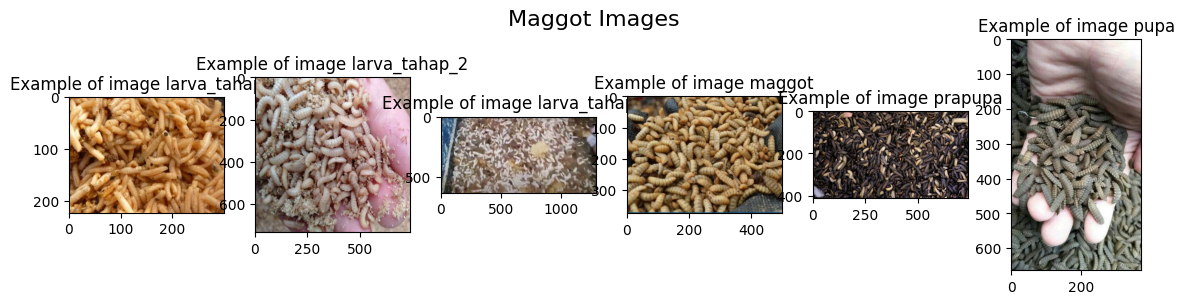

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(14, 3))
fig.suptitle('Maggot Images', fontsize=16)

# Plot one image from the first 4 image
for ii, maggot in enumerate(['larva_tahap_1' , 'larva_tahap_2', 'larva_tahap_3', 'maggot', 'prapupa', 'pupa']):
    dir = f'/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train/{maggot}'
    img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of image {maggot}')

In [ ]:
# **Step 1: Load Pre-trained Model**
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False
# Fine-tune beberapa layer terakhir
# for layer in base_model.layers[:-30]:
#     layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# **Step 3: Data Augmentation**
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
)

Found 1647 images belonging to 6 classes.
Found 441 images belonging to 6 classes.


In [ ]:
# **Step 2: Create the Custom Model**
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')  # Output layer (6 classes)
])

In [ ]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **Step 5: Define Callbacks**
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# **Step 5: Define Callbacks**
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Callback untuk menyimpan model terbaik berdasarkan val_loss
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Maggot_eachclass/model_11.keras',  # Path untuk menyimpan model terbaik
    monitor='val_loss',       # Metode evaluasi (misalnya, val_loss atau val_accuracy)
    save_best_only=True,      # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model, bukan hanya bobot
    mode='min',               # 'min' untuk loss, 'max' untuk akurasi
    verbose=1                 # Menampilkan log setiap penyimpanan model
)

class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Mendapatkan nilai accuracy dan val_accuracy dari logs
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        # Jika accuracy dan val_accuracy mencapai 80%, hentikan training
        if accuracy >= 0.90 and val_accuracy >= 0.90:
            print(f"\nStopping training at epoch {epoch + 1} as accuracy and val_accuracy >= 80%")
            self.model.stop_training = True

# Menggunakan callback ini saat training
custom_early_stopping = CustomEarlyStopping()


In [ ]:
# **Step 6: Train the Model**
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    # class_weight=class_weights,
    # steps_per_epoch=train_data.samples // train_data.batch_size,
    # validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[callbacks, checkpoint_callback, custom_early_stopping]
)

# **Step 7: Evaluate the Model**
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

model.save('/content/drive/MyDrive/Maggot_eachclass/model_11.h5')

# # Save the model in TFJS format
# output_dir = '/content/drive/MyDrive/Maggot_classification/tfjs_model'
# tfjs.converters.save_keras_model(model, output_dir)
# print(f"Model saved in TFJS format to {output_dir}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3374 - loss: 1.7164
Epoch 1: val_loss improved from inf to 0.98229, saving model to /content/drive/MyDrive/Maggot_eachclass/model_11.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 481s 8s/step - accuracy: 0.3394 - loss: 1.7108 - val_accuracy: 0.6304 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.6523 - loss: 0.9127
Epoch 2: val_loss improved from 0.98229 to 0.64182, saving model to /content/drive/MyDrive/Maggot_eachclass/model_11.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 960ms/step - accuracy: 0.6528 - loss: 0.9116 - val_accuracy: 0.7732 - val_loss: 0.6418 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.7621 - loss: 0.6488
Epoch 3: val_loss improved from 0.64182 to 0.49777, saving model to /content/drive/MyDrive/Maggot_eachclass/model_11.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - accuracy: 0.7620 - loss: 0.6486 - val_accuracy: 0.8458 - val_loss

Validation Loss: 0.2253, Validation Accuracy: 0.9184


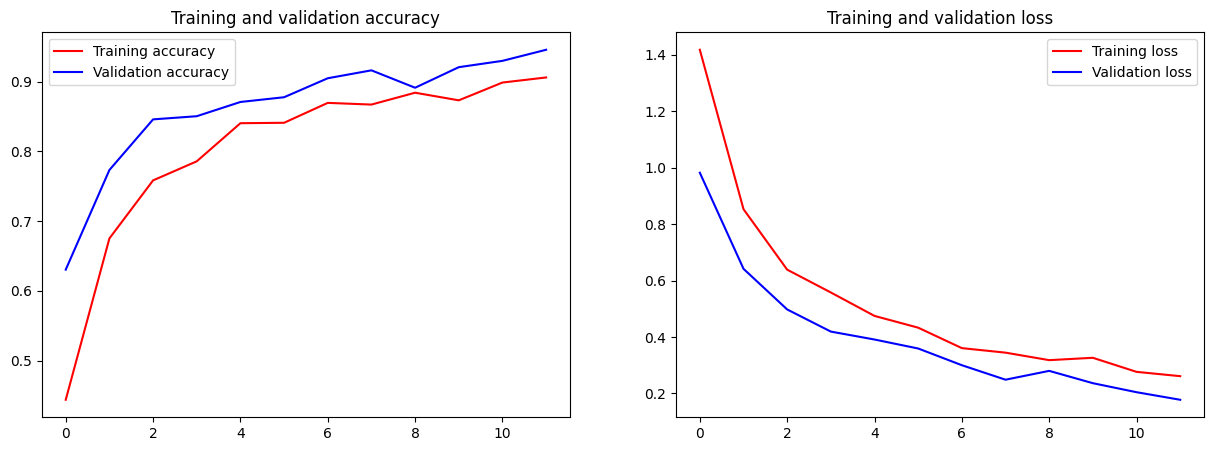

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Create a figure and two subplots

axes[0].plot(epochs, acc, 'r', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axes[0].set_title('Training and validation accuracy')
axes[0].legend(loc=0)

axes[1].plot(epochs, loss, 'r', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend(loc=0)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


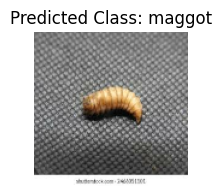

Predicted Class: maggot
Prediction Probabilities: [9.2322814e-05 1.4669352e-03 4.8320282e-05 6.5715897e-01 3.3922672e-01
 2.0067738e-03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


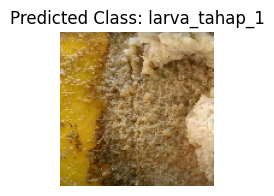

Predicted Class: larva_tahap_1
Prediction Probabilities: [6.6614902e-01 6.2856067e-05 3.3330122e-01 3.4259391e-04 1.2420934e-04
 2.0112397e-05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


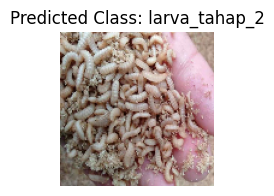

Predicted Class: larva_tahap_2
Prediction Probabilities: [1.0985715e-04 9.9093235e-01 1.3651671e-04 6.2841508e-03 5.6505279e-04
 1.9720399e-03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


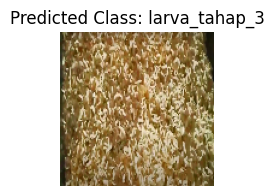

Predicted Class: larva_tahap_3
Prediction Probabilities: [9.0879772e-04 5.0708171e-05 9.9683207e-01 1.5915874e-06 2.2031616e-03
 3.7843572e-06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


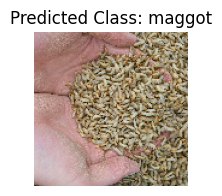

Predicted Class: maggot
Prediction Probabilities: [9.5806987e-05 3.7550434e-04 1.4117764e-05 9.9948502e-01 9.1706997e-06
 2.0377935e-05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


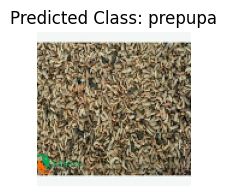

Predicted Class: prepupa
Prediction Probabilities: [2.0402303e-01 5.7487502e-03 4.8104467e-04 6.0880248e-02 6.6851854e-01
 6.0348418e-02]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


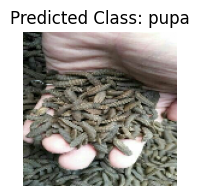

Predicted Class: pupa
Prediction Probabilities: [2.5731199e-08 7.4766290e-06 9.6560719e-08 6.0675156e-06 1.6819413e-07
 9.9998617e-01]


In [ ]:
# Daftar nama kelas (sesuaikan dengan class_indices dari generator data Anda)
class_names = ['larva_tahap_1', 'larva_tahap_2', 'larva_tahap_3', 'maggot', 'prepupa', 'pupa']

# model = load_model('/content/drive/MyDrive/Maggot_classification/model_finetune.h5')

def test_single_image(model, image_path):
    # Load gambar
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])  # Gunakan ukuran input sesuai model (InceptionV3: 299x299)
    img = tf.expand_dims(img, 0) / 255.0  # Normalisasi nilai piksel

    # Prediksi
    prediction = model.predict(img)
    predicted_index = np.argmax(prediction)  # Indeks prediksi
    predicted_class = class_names[predicted_index]  # Nama kelas berdasarkan indeks

    # Tampilkan gambar dengan hasil prediksi
    plt.figure(figsize=(2, 2))
    plt.imshow(img[0])
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')  # Hilangkan axis untuk estetika
    plt.show()

    # Cetak detail prediksi
    print(f"Predicted Class: {predicted_class}")
    print(f"Prediction Probabilities: {prediction[0]}")  # Probabilitas setiap kelas

# Uji gambar
test_single_image(model, "/content/drive/MyDrive/Maggot_eachclass/test_image/sebiji.jpg")
test_single_image(model, "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train/larva_tahap_1/tahap1(2).jpg")
test_single_image(model, "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train/larva_tahap_2/tahap2.jpg")
test_single_image(model, "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train/larva_tahap_3/tahap3(3).jpg")
test_single_image(model, "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train/maggot/tahap4(5).jpg")
test_single_image(model, "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train/prapupa/tahap5(2).jpg")
test_single_image(model, "/content/drive/MyDrive/Maggot_eachclass/sorted_2k_data/train/pupa/tahap6.jpg")
